In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open('./data/flowers_cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes('./data/flowers/train/')
print(classes)
print(c_2_idx)
print()
cls_2_name = {}
idx_2_fld = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    cls_2_name[int(cls)] = cat_to_name[str(k)]
    idx_2_fld[int(cls)] = str(k)
print(cls_2_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [3]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    
# Note transforms.ToTensor() scales input images
# to 0-1 range

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor()
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                    std=[0.229, 0.224, 0.225] )
    ])

train_data_path = "./data/flowers/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, 
                                              is_valid_file=check_image)

val_data_path = "./data/flowers/valid/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, 
                                            is_valid_file=check_image)
batch_size=32
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = None 

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

print(('load data ---> done!'))

load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
17


torch.Size([3, 224, 224])
tensor([ 7,  7, 13, 12, 11, 15,  2,  3,  3,  3,  3,  6, 11,  7,  9,  4, 11,  9,
        13,  1,  5, 15,  3,  6,  4, 13, 11,  5, 15, 11, 12,  8])


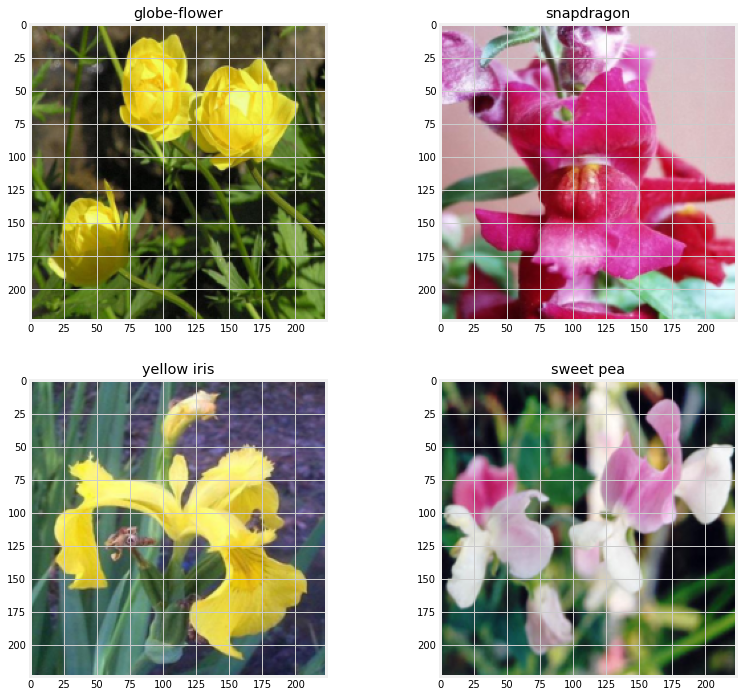

In [5]:
it = iter(train_data_loader)

dt,target = it.next()
print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
axes[0,1].imshow(dt[6].numpy().transpose(1, 2, 0))
axes[0,1].title.set_text(cls_2_name[int(target[6].numpy())])
axes[1,0].imshow(dt[11].numpy().transpose(1, 2, 0))
axes[1,0].title.set_text(cls_2_name[int(target[11].numpy())])
axes[1,1].imshow(dt[16].numpy().transpose(1, 2, 0))
axes[1,1].title.set_text(cls_2_name[int(target[16].numpy())])
plt.show()

In [12]:
################################
# network ResNet
################################

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because CIFAR is already 1x1 here:
        # disable avg pooling
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        #probas = F.softmax(logits, dim=1)
        return out



def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=False)
    return model

'''
net = resnet34(num_classes)
x = torch.randn(32,3,224,224)
y = net(x)
print(y.shape)
'''

'\nnet = resnet34(num_classes)\nx = torch.randn(32,3,224,224)\ny = net(x)\nprint(y.shape)\n'

In [14]:
model = resnet34(num_classes=num_classes)
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 17])


In [15]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        
        print('---- Training ----')
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {},  Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [16]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training model

In [17]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=10, device=device)

---- Training ----
---- Validating ----
Epoch: 1,  Training Loss: 2.43, Validation Loss: 5.77, accuracy = 0.18
---- Training ----
---- Validating ----
Epoch: 2,  Training Loss: 1.75, Validation Loss: 2.21, accuracy = 0.34
---- Training ----
---- Validating ----
Epoch: 3,  Training Loss: 1.60, Validation Loss: 1.71, accuracy = 0.40
---- Training ----
---- Validating ----
Epoch: 4,  Training Loss: 1.41, Validation Loss: 2.81, accuracy = 0.27
---- Training ----
---- Validating ----
Epoch: 5,  Training Loss: 1.32, Validation Loss: 2.18, accuracy = 0.36
---- Training ----
---- Validating ----
Epoch: 6,  Training Loss: 1.14, Validation Loss: 4.70, accuracy = 0.27
---- Training ----
---- Validating ----
Epoch: 7,  Training Loss: 1.06, Validation Loss: 2.45, accuracy = 0.37
---- Training ----
---- Validating ----
Epoch: 8,  Training Loss: 0.98, Validation Loss: 1.48, accuracy = 0.62
---- Training ----
---- Validating ----
Epoch: 9,  Training Loss: 0.84, Validation Loss: 0.94, accuracy = 0.72
-

### Test

In [18]:
test_data_path = "./data/flowers/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms, 
                                             is_valid_file=check_image)
batch_size=32
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

for batch in test_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = loss_fn(output,targets) 
    test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 1.50, accuracy = 0.60


tensor([ 5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11])
tensor([ 5,  5,  5,  6,  7,  6,  7,  3, 14,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9, 11,  9,  9, 10, 10,  2, 10,  0, 16,  2,  9])


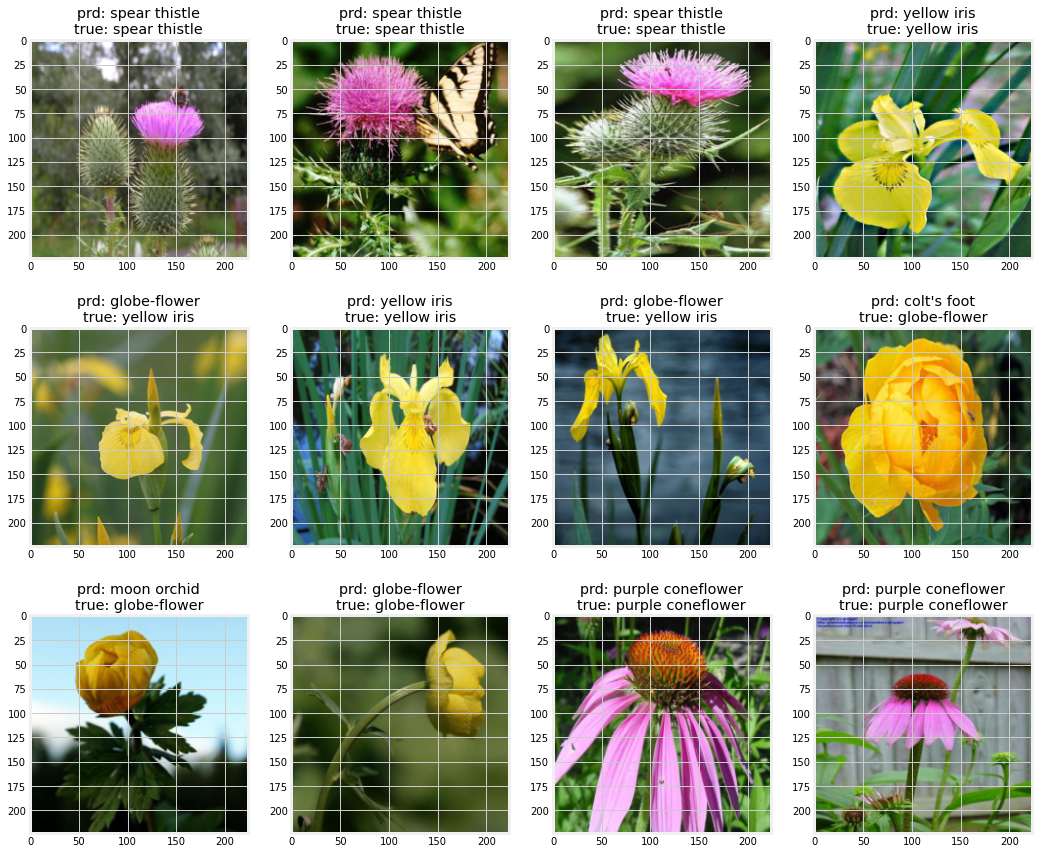

In [19]:
it = iter(test_loader)
it.next()
dt, labs = it.next()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

plt.figure(figsize=(16,15))
k = 0
for i in range(3):
    for j in range(4):
        ax = plt.subplot2grid((3,4), (i,j))
        #print(dt[k].numpy().transpose((1, 2, 0)).shape)
        tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + '\ntrue: ' + cls_2_name[int(labs[k].numpy())]
        ax.imshow(dt[k].numpy().transpose((1, 2, 0)))
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()